# Data Wrangling & EDA for Hemingway Next Word Prediction

## Introduction

Using *The Sun Also Rises* by Ernest Hemingway, this project will craft a next word prediction NLP object using Google's BERT. The wonderful venture Project Guttenberg (https://www.gutenberg.org/) provides free texts in electronic format. The text for this effort was chosen from Project Guttenberg and cleaned of its leading matter and liscence information.

## Table of Contents <a id="id0"></a>

1. [Import Packages](#id1)
2. [Load the Data](#id2)
3. [First Look Inside](#id3)
4. [Using spaCy for Initial Assessment](#id4)
5. [Frequency Counts for Nouns, Verbs, and Adjectives](#id5)
6. [Sentence Frequency by Word Count](#id6)
7. [Ngram Exploration](#id7)
8. [Word Embeddings](#id8)

<a id="id1"></a>

[Back to the TOC](#id0)


## Import Packages <a id="id1"></a>

In [2]:
import pandas as pd
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
from spacy.matcher import Matcher
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
import nltk, re, string, collections
from nltk.lm import NgramCounter
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
from IPython.display import Image

[Back to the TOC](#id0)


## Load the Data <a id="id2"></a>

The novel *The Sun Also Rises* by Ernest Hemingway can be found at Project Gutenberg here: https://www.gutenberg.org/ebooks/67138 . 

In [3]:
### The Project Gutenberg information and publisher copyright information was removed manually with a text processing program.
dataset = open("Sun_Also_Rises.txt", "r").read()
# Loading the dataset
path = 'Sun_Also_Rises.txt'
text = open(path).read().lower()

print('The text has {:,} separate items'.format(len(text)))


The text has 364,517 separate items


[Back to the TOC](#id0)


<a id="id3"></a>
## First Look Inside

In [67]:
## Creating a Word Cloud function from unprocessed text of Sun Also Rises
def create_word_cloud(string):
   cloud = WordCloud(background_color = "white", max_words = 100,  stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")
###Quick setup of the tokenizer from nltk
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

a= ' '.join(words) 

In [181]:
create_word_cloud(a)
##And creating a 2nd one with just 100 max_words which reads more cleanly

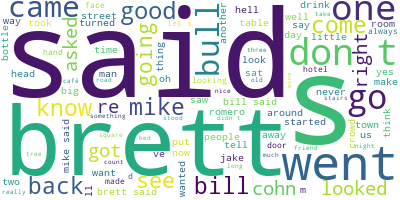

In [270]:
Image(filename="figures/Second_wordCloud.png")

In [68]:
## it looks like there are a lot of "s" hanging out by themselves, most likely the posessive 's' separated from removing and then spacing.
#How many of them as "words"? Same for free 't' of don't
def count_S(string):
    S_count = 0
    for item in (string):
        if item == "s":
            S_count += 1
    return S_count
s = count_S(a)
print("The count of free possesive Ses is {:,}".format(s))

def count_T(string):
    T_count = 0
    for item in (string):
        if item == "t":
            T_count += 1
    return T_count
t = count_T(a)
print("The count of free Tes is {:,}".format(t))

The count of free possesive Ses is 15,155
The count of free Tes is 26,404


[Back to the TOC](#id0)


## Using spaCy for Initial Assessment  <a id="id4"></a>

In [12]:
##Using spaCy to build an nlp pipeline
# Create a blank English nlp object
nlp = spacy.blank("en")

In [22]:
##checking to see if processing pipeline is up and running
doc = nlp("Hello world!")

# Iterate over tokens in a Doc
for token in doc:
    print(token.text)

Hello
world
!


In [71]:
#SAR will be the fullest text for "The Sun Also Rises"
SAR = nlp(text)
## Checking a random token from SAR
token2 = SAR[47]
span = SAR[147:156]
print(token2)
print(span)

sun
middleweight boxing champion of princeton. do not



In [15]:
### How much punctuation is there?
print("How many tokens are punctuation? {:,}".format(sum([token.is_punct for token in SAR])))

How many tokens are punctuation? 19,371


In [16]:
### How much numbers are there?
print("How many tokens are numbers? {:,}".format(sum([token.like_num for token in SAR])))

How many tokens are numbers? 748


In [17]:
### How much text-based words are there?
print("How many tokens are text words? {:,}".format(sum([token.is_alpha for token in SAR])))

How many tokens are text words? 68,315


In [146]:
### Working with their English pipeline (medium)
nlp = spacy.load("en_core_web_md")
nlp

In [147]:
SAR = nlp(text)

In [151]:
SAR[920:1000]



by that time, though, he had other things to worry about. he had been
taken in hand by a lady who hoped to rise with the magazine. she was
very forceful, and cohn never had a chance of not being taken in hand.
also he was sure that he loved her. when this lady saw that the magazine
was not going to rise, she became a little

In [148]:
### A quick check of how the pos parser is doing
span = SAR[100:125]
for token in span:
    print(token.text, token.pos_)

rivers NOUN
run VERB
into ADP

     SPACE
the DET
sea NOUN
; PUNCT
yet CCONJ
the DET
sea NOUN
is AUX
not PART
full ADJ
; PUNCT
unto ADP
the DET
place NOUN
from ADP
whence ADP
the DET

     SPACE
rivers NOUN
come VERB
, PUNCT
thither ADV


In [23]:
### looking at a few NER instances
for token in SAR.ents[100:125]:
    print(token.text, token.label_)
### dates, times, gpes, persons, org, and cardinal numbers seem to work well

the quarter DATE
the quarter DATE
one night TIME
night TIME
paris GPE
two CARDINAL
south america LOC
paris GPE
first ORDINAL
second ORDINAL
two hours TIME
robert PERSON
all last night TIME
3 CARDINAL
spring night TIME
robert PERSON
first ORDINAL
one CARDINAL
un ORG
paris GPE
the avenue de l’opéra ORG
new york GPE
the hour TIME
america GPE
the rue de rivoli ORG


In [48]:
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "men"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [49]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

young men
young men
several men
more men
other men


In [50]:
### Doing the same for "women"
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "women"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [51]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

several women
american women


 Not a lot of adjective description in general here, and certainly fewer for women. Let's get a look at just ADJ + NOUN combos.

In [187]:
### Working with Matcher to find Adj and Noun combos
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
matcher.add("Adj_Noun", [pattern])
matches = matcher(SAR)

In [194]:
for match_id, start, end in matches[0:30]:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

lost generation
middleweight boxing
inner comfort
nice boy
young gentlemen
certain satisfaction
strange sort
last year
middleweight boxing
simple people
middleweight boxing
jewish families
military school
good end
nice boy
friendly boy
flattened nose
unattractive mould
domestic unhappiness
rich wife
healthful shock
literary people
short time
editorial page
sole editor
other things
literary friend
second year
careless possession
many people


Some telling pairings here. It would be good to look at the most common basic parts of speech.

In [92]:
print(sum(len(token) for token in SAR)/len(SAR))

3.1410961030895823


The word length average for SAR is quite short.

[Back to the TOC](#id0)

<a id="id5"></a>
## Frequency Counts for Nouns, Verbs, and Adjectives

In [195]:
### drawing from this TDS site: https://towardsdatascience.com/lovecraft-with-natural-language-processing-part-2-tokenisation-and-word-counts-f970f6ff5690
### Will use lemmatization here to get unified counts
def create_word_counts_by_pos(text, list_of_pos, word_count_dict_input = None):
    """
    takes a raw text file
    tokenizes and lemmatizes it
    limits inspection to list_of_pos types of words
    counts the individual lemmas
    returns a dictionary, keys are POSes in list_of_pos
    values are dictinaries with word counts
    """
    doc = nlp(text)
    
    if word_count_dict_input is None: 
        word_count_dict = {}
        for part_of_speech in list_of_pos:
            word_count_dict[part_of_speech] = {}
    else:
        word_count_dict = word_count_dict_input

    for token in doc: 
        part_of_speech = token.pos_

        if part_of_speech in list_of_pos:
            word_lemma = token.lemma_
            current_count = word_count_dict[part_of_speech].get(word_lemma, 0)
            current_count += 1
            word_count_dict[part_of_speech][word_lemma] = current_count

    return word_count_dict

def filter_word_count_dict_to_frequent(word_count_dict, threshold):
    """
    Loops through word_count_dict, only keeps items where 
    value is higher than a certain threshold
    """
    frequent_word_count_dict = {}

    list_of_pos = word_count_dict.keys()

    for part_of_speech in list_of_pos:
        frequent_word_count_dict[part_of_speech] = {}
        for key in word_count_dict[part_of_speech]:
            if word_count_dict[part_of_speech][key] > threshold:
                frequent_word_count_dict[part_of_speech][key] = \
                word_count_dict[part_of_speech][key]
                
    return frequent_word_count_dict

def collect_most_frequent_words(word_count_dict, number_to_collect):
    """
    word_count_dict is assumed to be in a format where keys are part-of-speech, 
    values are counts
    number_of_collect: we will collect this amount from each group
    if there is a tie: the one that appeared first
    """

    list_of_pos = word_count_dict.keys()
    most_frequent_words = {}

    for part_of_speech in list_of_pos:
        most_frequent_words[part_of_speech] = \
        sorted(word_count_dict[part_of_speech].items(), \
            key=lambda x: x[1], reverse = True)[:number_to_collect] 
        
    return most_frequent_words


In [209]:
list_of_pos = ['NOUN']

In [210]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [211]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [223]:
nouns_df = pd.DataFrame.from_dict(frequent_word_count_dict)
nouns_df.iloc[5:10,:]

,NOUN
ass,13
back,27
bag,50
balcony,13
bar,45


In [200]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['VERB']

In [201]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [202]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [203]:
verbs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
verbs_df.head()

,VERB
ask,176
be,183
become,16
behave,11
believe,21


In [225]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['ADJ']

In [226]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [227]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [240]:
adjs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
adjs_df.head()

,ADJ
asleep,12
awful,13
bad,47
beautiful,12
big,76


In [229]:
print(nouns_df.shape, verbs_df.shape, adjs_df.shape)

(213, 1) (142, 1) (83, 1)


In [241]:
adjs_df.reset_index(inplace=True)

#verbs_df.reset_index(inplace=True)

In [242]:
adjs_df.columns

Index(['index', 'ADJ'], dtype='object')

In [245]:
adjs_df.rename(columns={'index':'ADJ'}, inplace=True)
adjs_df.columns
#adjs_df.drop(columns=['level_0'], inplace=True)

adjs_df.sort_values('count', ascending=False).head()

,ADJ,count
30,good,224
40,little,106
59,right,94
53,other,82
4,big,76


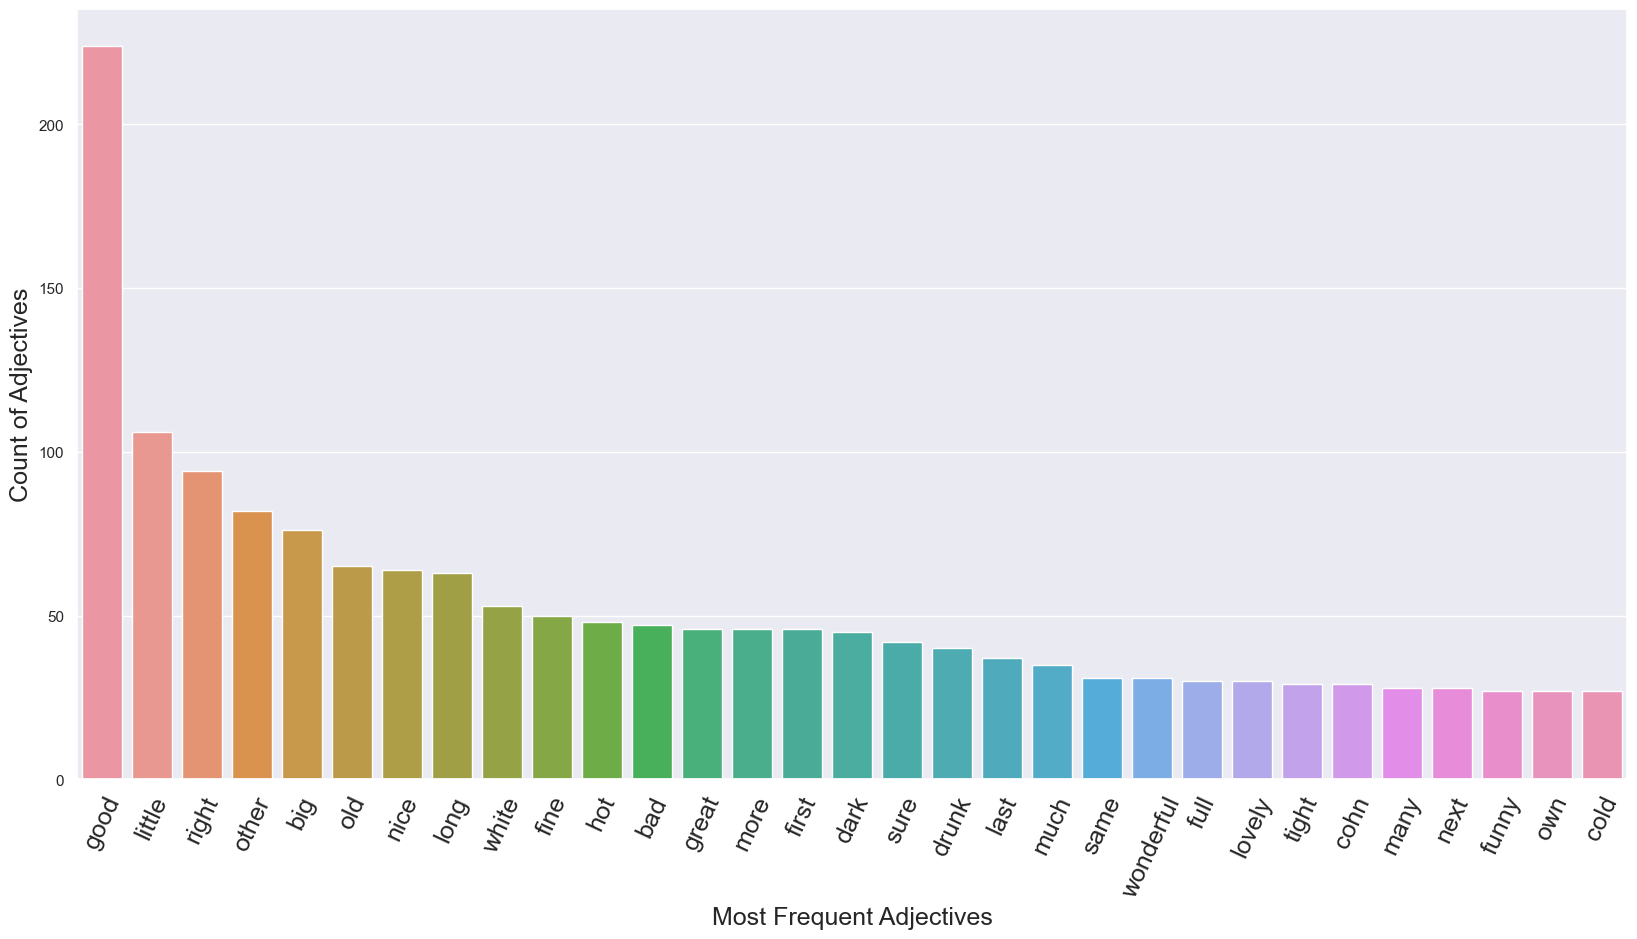

In [247]:
sns.barplot(x="ADJ", y='count', data=adjs_df.query('count > 25').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Adjectives', fontsize=18)
plt.ylabel('Count of Adjectives', fontsize=18)
plt.xticks(rotation = 65, fontsize=18)
plt.savefig('Count for Frequent Adjectives')
plt.show()


In [254]:
#nouns_df.reset_index(inplace=True)
nouns_df.drop("level_0", axis=1, inplace=True)
#nouns_df.drop([0,1], inplace=True)
nouns_df.head()

,index,NOUN
2,afternoon,13
3,arcade,18
4,arm,36
5,ass,13
6,back,27


In [256]:
nouns_df.rename(columns={'NOUN':'count', 'index':'Noun'}, inplace=True)

#nouns_df.sort_values('count', ascending=False).head()

### Issue here is that possessive 's' which is attached to nouns is itself counted as a frequent noun (77 times)
### Dropping it now and will figure out how to use it:
#nouns_df.drop([221], inplace=True)
nouns_df.sort_values('count',ascending=False).head(10)

,Noun,count
27,bull,314
18,bill,298
187,time,137
142,people,125
182,table,122
179,street,119
117,man,115
158,room,102
206,wine,97
135,night,97


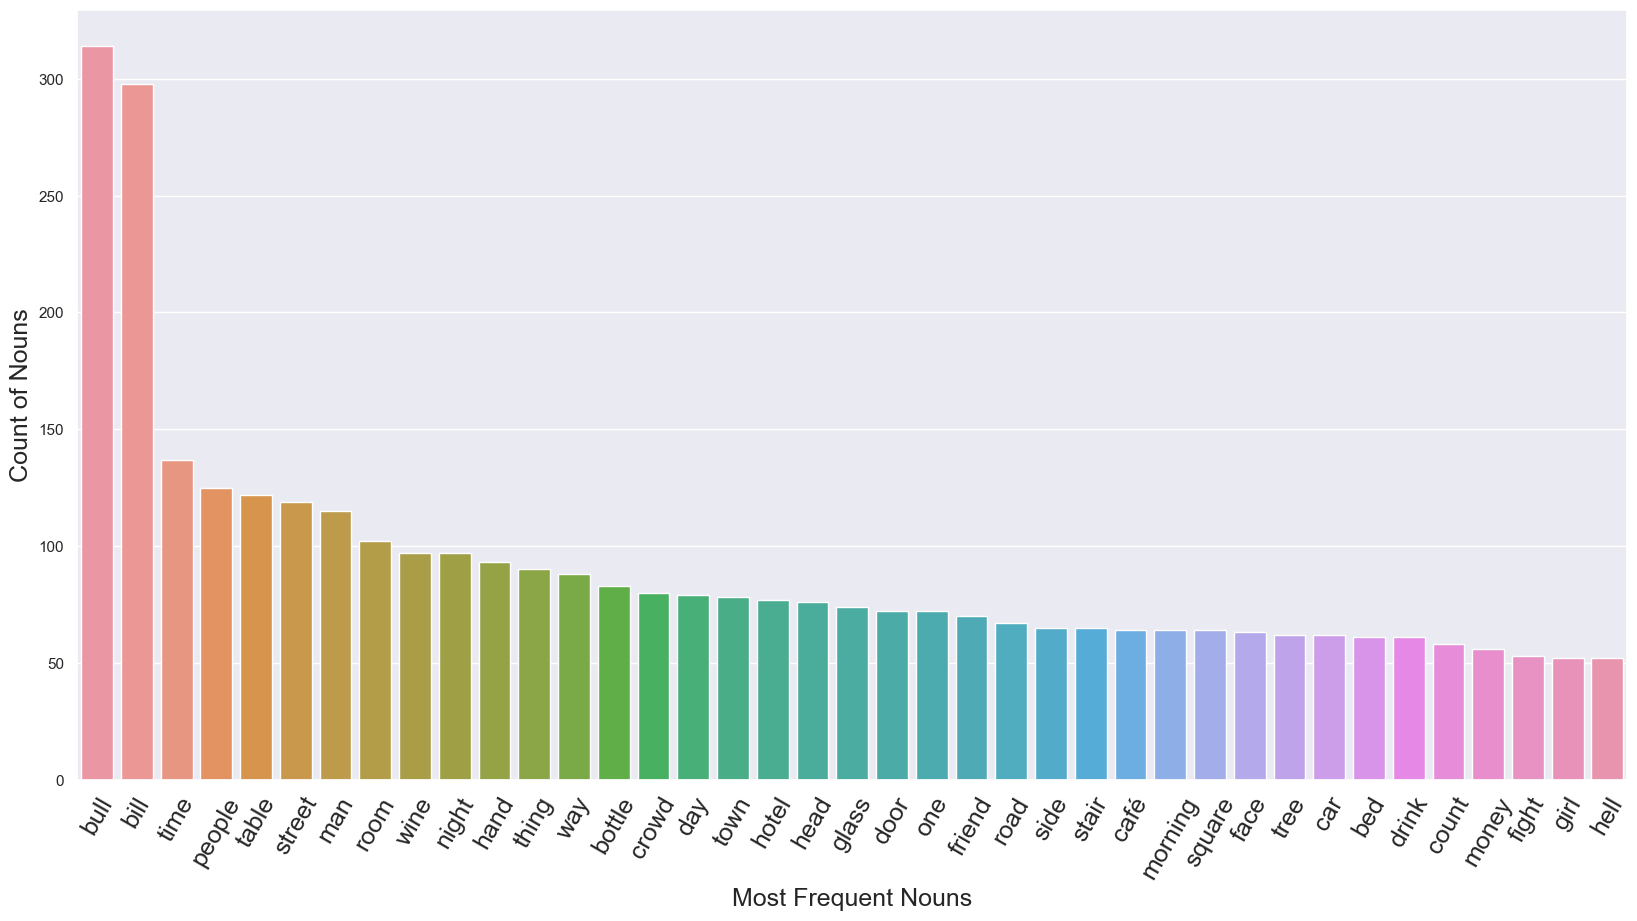

In [257]:
sns.barplot(x="Noun", y='count', data=nouns_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Nouns', fontsize=18)
plt.ylabel('Count of Nouns', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Nouns')
plt.show()

### This one is really telling

In [258]:
verbs_df.columns

Index(['index', 'VERB'], dtype='object')

In [261]:
#verbs_df.rename(columns={'VERB':'count', 'index':'Verb'}, inplace=True)
#verbs_df.head()
#verbs_df.drop([138], inplace=True) ## The apostrophe
verbs_df.sort_values('count',ascending=False).head(10)
### Here the apostophe is considered a verb. Cute. I am sure it would be proud. But let's drop it.

,Verb,count
94,say,1103
37,go,769
42,have,429
16,come,413
35,get,399
66,look,296
95,see,288
54,know,264
129,want,220
1,be,183


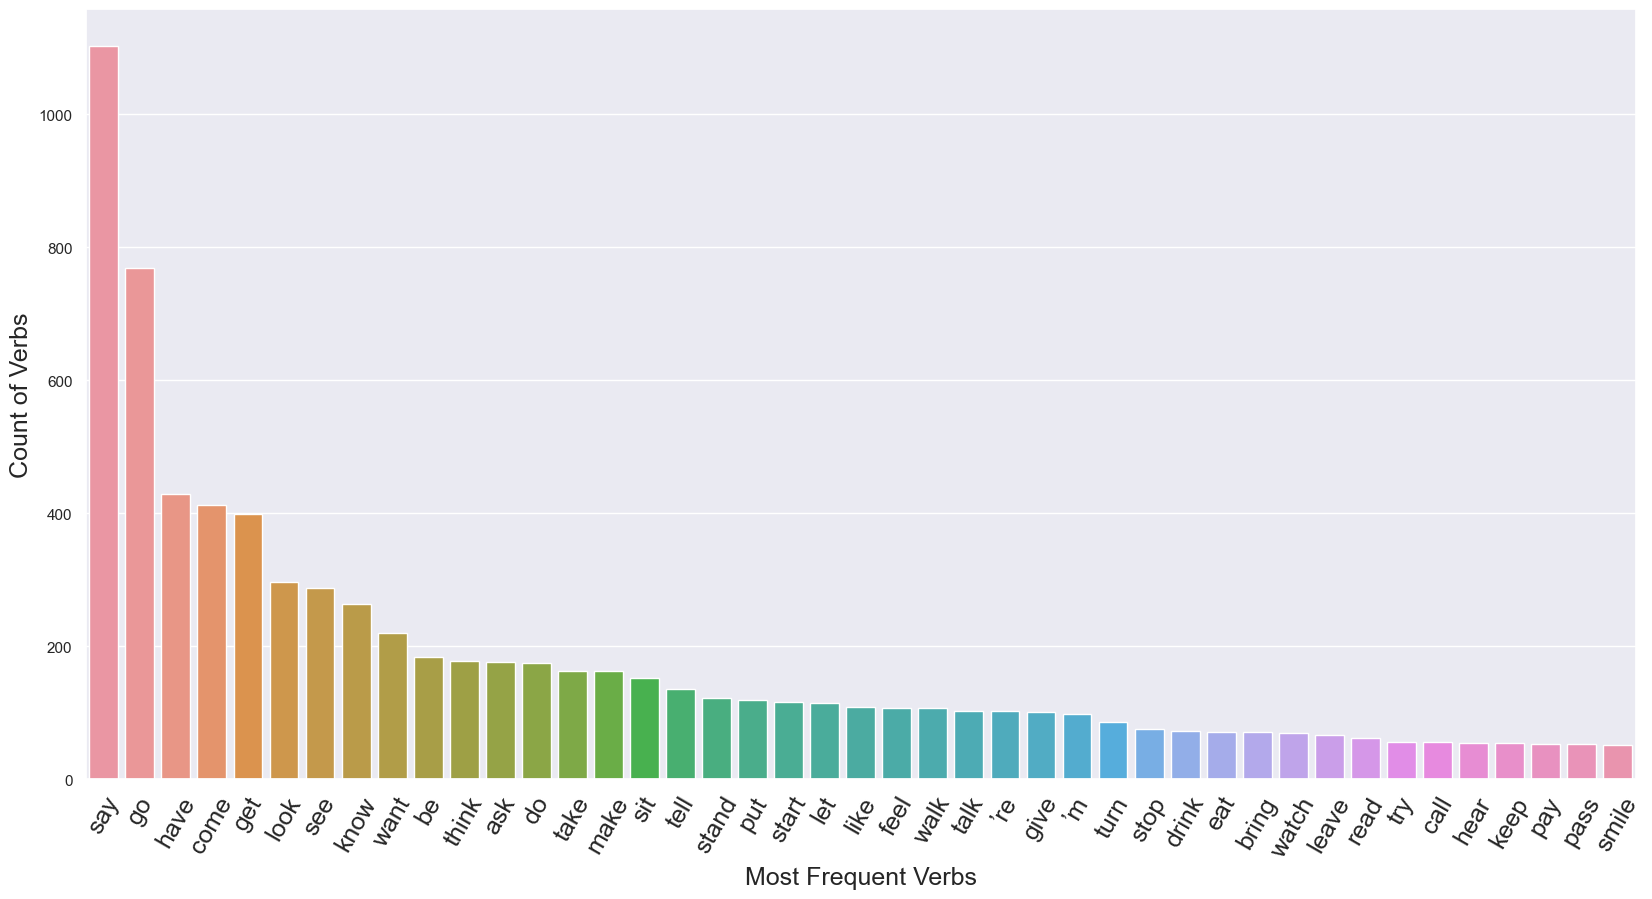

In [262]:
sns.barplot(x="Verb", y='count', data=verbs_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Verbs', fontsize=18)
plt.ylabel('Count of Verbs', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Verbs')
plt.show()
### This one is really telling too; so many Old English verbs

[Back to the TOC](#id0)

<a id="id6"></a>
## Sentence Frequency by Word Count

Hemingway is known for a sparse, direct style. Clearly his nouns, verbs, and adjectives support that view considering the high rate of Old English vocabulary in his writing. Does the length of his sentences also create this writing style?

In [233]:
### from https://spacy.io/usage/linguistic-features#sbd
assert SAR.has_annotation("SENT_START")
sentences = []
for sent in SAR.sents:
    sentences.append(sent.text)

In [256]:
len(sentences)

5770

In [302]:
sent_df = pd.DataFrame(sentences)
sent_df.rename(columns={0:'sentence'}, inplace=True)
sent_df.head(10)

,sentence
0,”you are all a lost generation.”\n\n ...
1,. .
2,"the sun also ariseth, and the\n sun goeth d..."
3,\n
4,"the wind goeth toward the south, and turneth a..."
5,returneth\n again according to his circuits. .
6,. .
7,all the rivers run into\n the sea; yet the ...
8,\n\n ...
9,do not\nthink that i am very much impressed by...


In [303]:

sent_df['word count'] = sent_df['sentence'].apply(lambda x: len(x.split(' ')))


In [306]:
### getting rid of the epigraphs for this purpose
#sent_df.drop(index=sent_df.index[:9], axis=0, inplace=True)
#sent_df.reset_index(inplace=True)
#sent_df.drop(columns='index', inplace=True)
sent_df.head(30)

,sentence,word count
0,do not\nthink that i am very much impressed by...,20
1,"he cared nothing for boxing, in fact he dislik...",33
2,there was a certain inner comfort in knowing h...,32
3,he was spider\nkelly’s star pupil.,5
4,spider kelly taught all his young gentlemen to...,24
5,but it seemed to fit cohn.,6
6,he was really\nvery fast.,4
7,he was so good that spider promptly overmatche...,14
8,"this increased cohn’s distaste for\nboxing, bu...",21
9,in his last year at princeton he read\ntoo muc...,14


In [308]:
sent_df.sort_values('word count', ascending = False)

,sentence,word count
2079,i wondered if there was anything else i might\...,182
4939,since then he has killed more than a thousand ...,147
4942,"sometimes he turned to smile that\ntoothed, lo...",102
5012,he hasn’t learned it yet.”\n\n“but i thought h...,98
1771,“you can’t blame him such a hell of a lot.”\n\...,88
...,...,...
1713,“hel-lo!,1
1714,hel-lo!,1
5523,\n\n,1
3321,\n\n,1


In [321]:
sent_mean = np.around(np.mean(sent_df['word count']), decimals=2)
sent_std = np.around(np.std(sent_df['word count']), decimals=2)
sent_range = np.max(sent_df['word count']) - min(sent_df['word count'])
print('The mean word count per sentence is {}, \n the standard deviation is {}, \n and the range is {}'\
      .format(sent_mean, sent_std, sent_range))

The mean word count per sentence is 11.08, 
 the standard deviation is 9.66, 
 and the range is 181


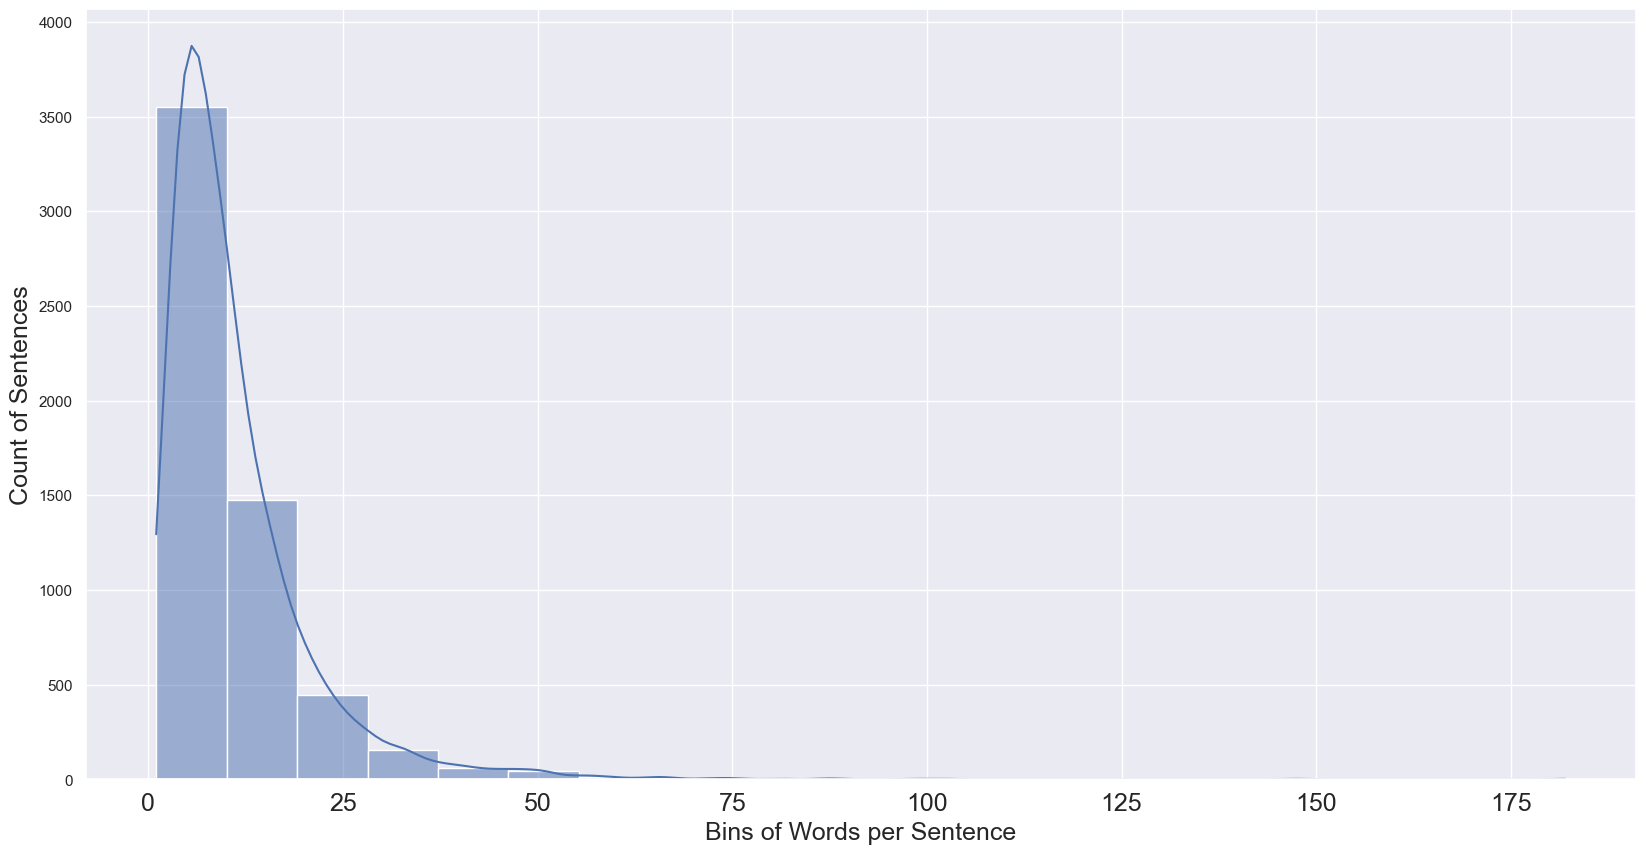

In [343]:
sns.histplot(data=sent_df, x="word count", bins=20, kde=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of word count per sentence')

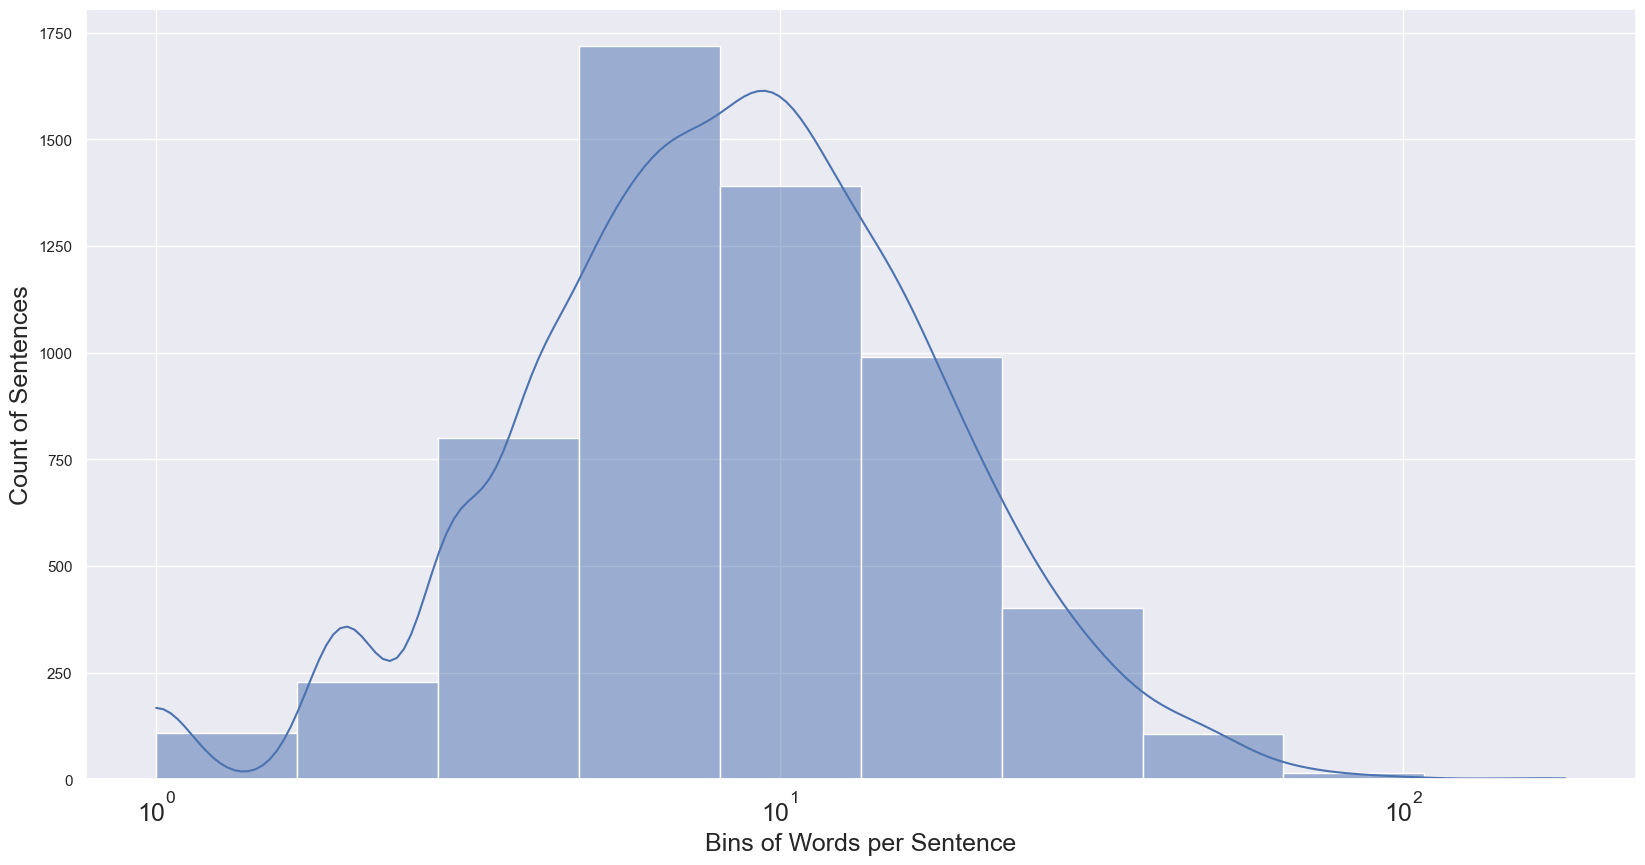

In [344]:
sns.histplot(data=sent_df, x="word count", bins=10, kde=True, log_scale=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of log transformed word count per sentence')

The log transformed word count per sentence provides a more coherent view of the variability for sentence length.

[Back to the TOC](#id0)

<a id="id7"></a>
## Ngram Exploration

In [18]:
##After missing the rightward " and ' marks, a new string pattern was created.
full_match= "[!”\"#’$%&'()*+,-./:;<=>“?@[\]^_`{|}~]"
print(full_match)

[!”"#’$%&'()*+,-./:;<=>“?@[\]^_`{|}~]


In [22]:
text_no_punct = text.translate(str.maketrans('','',full_match))
print(text_no_punct[1000:1500])

ed it painfully and thoroughly to counteract the feeling
of inferiority and shyness he had felt on being treated as a jew at
princeton there was a certain inner comfort in knowing he could knock
down anybody who was snooty to him although being very shy and a
thoroughly nice boy he never fought except in the gym he was spider
kellys star pupil spider kelly taught all his young gentlemen to box
like featherweights no matter whether they weighed one hundred and five
or two hundred and five pounds 


In [37]:
all_stopwords = nlp.Defaults.stop_words
text3 = word_tokenize(text_no_punct)
text4 = [word for word in text3 if not word in all_stopwords]

In [38]:
print(text4[3000:3200])

['checkbook', 'deducted', 'checks', 'drawn', 'month', 'discovered', 'balance', '183260', 'wrote', 'statement', 'letter', 'wedding', 'announcement', 'mr', 'mrs', 'aloysius', 'kirby', 'announce', 'marriage', 'daughter', 'katherine—i', 'knew', 'girl', 'man', 'marrying', 'circularizing', 'town', 'funny', 'felt', 'sure', 'remember', 'anybody', 'like', 'aloysius', 'good', 'catholic', 'crest', 'announcement', 'like', 'zizi', 'greek', 'duke', 'count', 'count', 'funny', 'brett', 'title', 'lady', 'ashley', 'hell', 'brett', 'hell', 'lady', 'ashley', 'lit', 'lamp', 'bed', 'turned', 'gas', 'opened', 'wide', 'windows', 'bed', 'far', 'windows', 'sat', 'windows', 'open', 'undressed', 'bed', 'outside', 'night', 'train', 'running', 'streetcar', 'tracks', 'went', 'carrying', 'vegetables', 'markets', 'noisy', 'night', 'sleep', 'undressing', 'looked', 'mirror', 'big', 'armoire', 'bed', 'typically', 'french', 'way', 'furnish', 'room', 'practical', 'suppose', 'ways', 'wounded', 'suppose', 'funny', 'pajamas',

In [41]:
### Drawn from https://github.com/EricFillion/N-Grams 
def main(doc):
    result = bigrams(doc)

    for element in result:
        for token in element:
            print(token, end=' ')
        print()  # new line

In [42]:
main(text4[100:120])

weighed pounds 
pounds fit 
fit cohn 
cohn fast 
fast good 
good spider 
spider promptly 
promptly overmatched 
overmatched got 
got nose 
nose permanently 
permanently flattened 
flattened increased 
increased cohns 
cohns distaste 
distaste boxing 
boxing gave 
gave certain 
certain satisfaction 


In [46]:
def bigram(doc):
    # create a list for the result
    result2 = list()
    # create a list that contains no punctuation
    sentence2 = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence2.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence2) - 1):
        first_word = sentence2[word]
        second_word = sentence2[word + 1]
        element2 = [first_word.text, second_word.text]
        result2.append(element2)

    return result2

In [43]:
text5 = ' '.join(text4)
SAR_fresh = nlp(text5)

In [44]:
print(SAR_fresh[1000:1200])

ve plenty worry time im worrying want south america listen robert going country doesnt difference ive tried cant away moving place theres youve south america south america hell went way feel exactly good town dont start living life paris im sick paris im sick quarter stay away quarter cruise happens happens walked night happened bicycle cop stopped asked papers wasnt town nice night dont care paris sorry thing right away ran stubbornnesses south america fix like paris got idea book suppose second came book said ive got upstairs cables yes ive got cables mind come sit office come sat outer room read papers editor publisher worked hard hours sorted carbons stamped byline stuff couple big manila envelopes rang boy gare st lazare went room robert cohn asleep big chair asleep head arms like wake wanted lock office shove hand shoulder shook head cant said head deeper arms cant robert said shook shoulder looked smiled blinked talk loud wasnt clear god rotten dream typewriter sleep guess didnt

In [47]:
bi_new = bigram(SAR_fresh)

In [48]:
def trigram(doc):
    # create a list for the result
    result3 = list()
    # create a list that contains no punctuation
    sentence3 = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence3.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence3) - 2):
        first_word = sentence3[word]
        second_word = sentence3[word + 1]
        third_word = sentence3[word + 2]
        element3 = [first_word.text, second_word.text, third_word.text]
        result3.append(element3)

    return result3

In [49]:
tri_new = trigram(SAR_fresh)

In [50]:
bigram_df=pd.DataFrame(bi_new, columns=('first_word', 'second_word'))
trigram_df=pd.DataFrame(tri_new, columns=('first_word', 'second_word', 'third_word'))


In [51]:
bigram_df.tail()

,first_word,second_word
30247,said,is
30248,is,nt
30249,nt,pretty
30250,pretty,think
30251,think,end


In [52]:
trigram_df.tail()

,first_word,second_word,third_word
30246,yes,said,is
30247,said,is,nt
30248,is,nt,pretty
30249,nt,pretty,think
30250,pretty,think,end


In [58]:
### Starting fresh here: Drawing from https://www.kaggle.com/code/scratchpad/notebookdbaabe5532/
# Function n_gram: splits the words in order to given parameter
# Parameter n: it's the "n" number for "n-gram"
def n_gram(n):                                             
    n_grams = ngrams(text5.split(), n)
    return n_grams

In [59]:
sentences = []
df_frequency = []

In [60]:
# Function frequency: counts the frequency of the each "n-gram" output
# Parameter grammed: it takes the function "n_gram"s return as value. Briefly, the grammed text.
def frequency(grammed):
    sentences.clear()
    df_frequency.clear()
    freq = nltk.FreqDist(grammed)
    for k, v in freq.items():
        sentences.append(k)                     # Sentences is a list, stores the grams(ignores duplicates)
        df_frequency.append(v)                  # df_frequency is a list, stores the frequency of grams
        

In [61]:
# Function create_plot: it creates a plot for given grams
# Parameter num: it's a number to send it to "n_gram" function
def create_plot(num):
    frequency(n_gram(num)) # Send "num" parameter to "n_gram func." and send the result to "frequency func."

    gram_frame = pd.DataFrame(sentences)       # gram_frame is the data frame to store grams and freq.

    gram_frame['frequencies'] = df_frequency
    if num == 2:
        gram_frame.columns = ['first', 'second', 'frequencies']
    if num == 3:
        gram_frame.columns = ['first', 'second', 'third', 'frequencies']

    gram_frame.sort_values("frequencies", axis=0, ascending=False, inplace=True, na_position='last')

    gram_frame = gram_frame.head(20)            # Only take the top 20 of gram_frame

    total = sum(df_frequency)

    gram_frame["ratio"] = gram_frame['frequencies'].div(total)   # Additional, ratio is added

    plt.rcdefaults()
    fig, ax = plt.subplots()

    if num == 2:
        grams = gram_frame["first"] + " " + gram_frame["second"]
    if num == 3:
        grams = gram_frame["first"] + " " + gram_frame["second"] + " " + gram_frame["third"]

    # Create plot
    y_pos = np.arange(len(grams))
    performance = gram_frame["frequencies"]

    ax.barh(y_pos, performance)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(grams)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title('2-3 grams')

    plt.show()
    display(gram_frame)

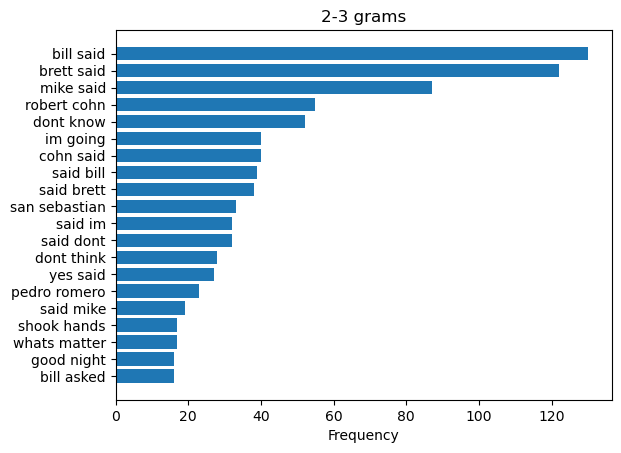

,first,second,frequencies,ratio
6474,bill,said,130,0.004516
1944,brett,said,122,0.004238
7329,mike,said,87,0.003023
46,robert,cohn,55,0.001911
492,dont,know,52,0.001807
1785,im,going,40,0.001390
466,cohn,said,40,0.001390
6628,said,bill,39,0.001355
2008,said,brett,38,0.001320
5411,san,sebastian,33,0.001146


In [62]:
create_plot(2)   # Create plot for bigram 

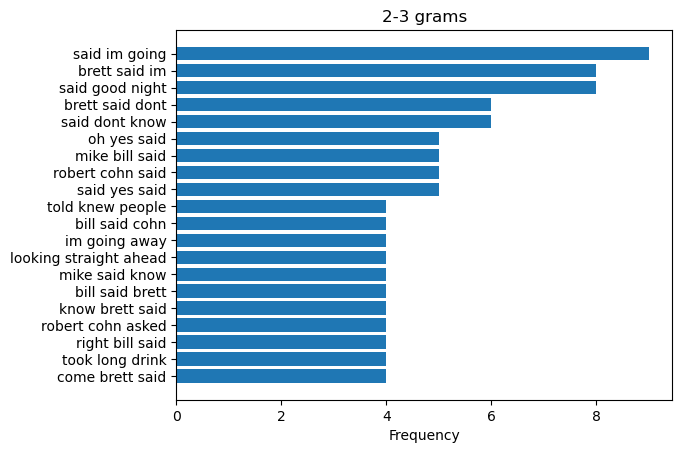

,first,second,third,frequencies,ratio
2708,said,im,going,9,0.000313
2707,brett,said,im,8,0.000278
2285,said,good,night,8,0.000278
14895,brett,said,dont,6,0.000208
2517,said,dont,know,6,0.000208
2771,oh,yes,said,5,0.000174
21085,mike,bill,said,5,0.000174
2157,robert,cohn,said,5,0.000174
1623,said,yes,said,5,0.000174
3397,told,knew,people,4,0.000139


In [63]:
create_plot(3)   # Create plot for trigram

[Back to the TOC](#id0)

<a id="id8"></a>
## Word Embeddings

In [64]:
### Changed up to the medium spaCy model
for token in SAR_fresh[1000:1025]:
    print(token.text)

ve
plenty
worry
time
i
m
worrying
want
south
america
listen
robert
going
country
does
nt
difference
i
ve
tried
ca
nt
away
moving
place


In [179]:
#A truncated quick look at 10% of the vector
print(SAR_fresh[1000].text, SAR_fresh[1000].vector[:30])

look [ 2.4031   3.946   -1.878   -1.5863   1.2682   2.1427   0.5023   3.816
 -8.0236   5.9172   7.0763   2.8992  -8.5411  -2.6027   7.9232   2.9896
  2.9888  -3.9033  -0.62906  0.29511  2.1008   1.4735  -1.132   -7.5735
 -2.6464   4.8237  -2.8272  -5.4246   5.545    2.7954 ]


In [160]:
look = SAR_fresh[1000]
like = SAR_fresh[1001]
look.similarity(like)

0.4681655764579773

Let's compare the first and last chapter of the book to see if there is much difference across the novel. It might be that predicting from a model retrained on the last chapters is different from one retrained on the first chapters.

In [161]:
### Will look at Ch 1 vs Ch 19 for similarities
dataset1 = open("ch1.txt", "r").read()
# Loading the dataset
path1 = 'ch1.txt'
chapter_1 = open(path1).read().lower()

print('The text has {:,} separate items'.format(len(chapter_1)))

The text has 7,273 separate items


In [162]:
### Will look at Ch 1 vs Ch 19 for similarities
dataset2 = open("ch19.txt", "r").read()
# Loading the dataset
path1 = 'ch19.txt'
chapter_19 = open(path1).read().lower()

print('The text has {:,} separate items'.format(len(chapter_19)))

The text has 33,129 separate items


In [164]:
chapter_1_np = re.sub(match, "", chapter_1) 
chapter_19_np = re.sub(match, "", chapter_19) 

In [165]:
chapter_1_nostops = remove_stopwords(chapter_1_np)
chapter_19_nostops = remove_stopwords(chapter_19_np)

In [169]:
print(chapter_1_nostops[100:150],"\n", chapter_19_nostops[100:150])

 boxing fact disliked learned painfully thoroughly 
 king rocketsticks square cafés opening waiters car


In [170]:
CH1 = nlp(chapter_1_nostops)

In [171]:
CH19 = nlp(chapter_19_nostops)

In [176]:
print("The similarity score between Chapter 1 and Chapter 19 is {}".\
      format(round(CH1.similarity(CH19),2)))

The similarity score between Chapter 1 and Chapter 19 is 0.92


This similarity score between the first and last chapter is quite high considering that the last chapter is almost five times as large as the first chapter.